# grainanalyser
> workflow to read grain-size distributions from the lab, with treating grain sizes as compositional data and therefore processing them using the Aitchison's log-ratio approach

## Prerequisites

* only works for one directory at a time
* only works for csv files
* only works for files in laserscannerformat

In [1]:
%load_ext lab_black

In [2]:
from Functions import *

In [3]:
# install packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob as glob


import composition_stats as comp

## note that package is not applicable in pandas
## --> therefore convert dataframe columns to array (.values)

In [4]:
pd.set_option("display.max_rows", 15)  # none to view all rows

### Data Wrangling

In [5]:
filepath = "Data\Test_GS-020.csv"
extract_depth(filepath)

'020'

In [7]:
filepath = "Data/*.csv"
grainsizes = read_gs_to_df(filepath)

grainsizes_prep = cut_off_zeros(grainsizes)

### Convert Grainsize to Krumbein Phi Scale

$$\phi = -\log_2 D/D_0\text{,} $$

> relevant for later classification

In [8]:
grainsizes_prep["gs_phi"] = diameter_2_krumbein_phi(
    channelwidth=grainsizes_prep["Kanaldurchmesser_unten_um"], unit="um"
)

***

### clr on Vol_% column

> hier wird die clr mithilfe von composition.stats berechnet (alle aliquoten messungen

> Zeros sind an den rändern abgeschnitten, sodasss nur noch die nullstellen innerhalb probleme machen

> diese werden mit `multiplicative_replacement` ersetzt

> closure: summe alle werte = 1



In [9]:
grainsizes_clr = gs_simplex_2_rplus(dataframe=grainsizes_prep, depth_colum="depth")

### Summarize the subsamples into one mean curve!

In [10]:
grainsizes_summarize = mean_curves_clr(dataframe=grainsizes_clr, depth_colum="depth")
grainsizes_summarize

,depth,Kanaldurchmesser_unten_um,Vol_%,gs_phi,Vol_clr_mean,Vol_clr_median,Vol_clr_std
0,20.0,0.043910,0.000247,14.475075,-7.354081,-7.354081,1.854440
1,20.0,0.048203,0.000419,14.340509,-6.332642,-6.332642,1.156099
2,20.0,0.052916,0.000844,14.205942,-5.465563,-5.465563,0.918792
3,20.0,0.058089,0.001747,14.071378,-4.771369,-4.771369,0.966281
4,20.0,0.063768,0.003379,13.936810,-4.144644,-4.144644,1.012821
...,...,...,...,...,...,...,...
955,112.0,213.221000,0.019420,2.229579,-4.874464,-4.874464,3.438009
956,112.0,234.066000,0.000000,2.095013,-7.625638,-7.625638,0.005902
957,112.0,256.948000,0.000000,1.960452,-7.625638,-7.625638,0.005902
958,112.0,282.068000,0.000000,1.825885,-7.625638,-7.625638,0.005902


### Save to csv

In [11]:
filepath = "grainsizes_summarize.csv"
grainsizes_summarize.to_csv(filepath, index=False)

**********
## Plotting

> plotting all avg. curves in one plot (viridis)


In [12]:
from matplotlib.pyplot import cm

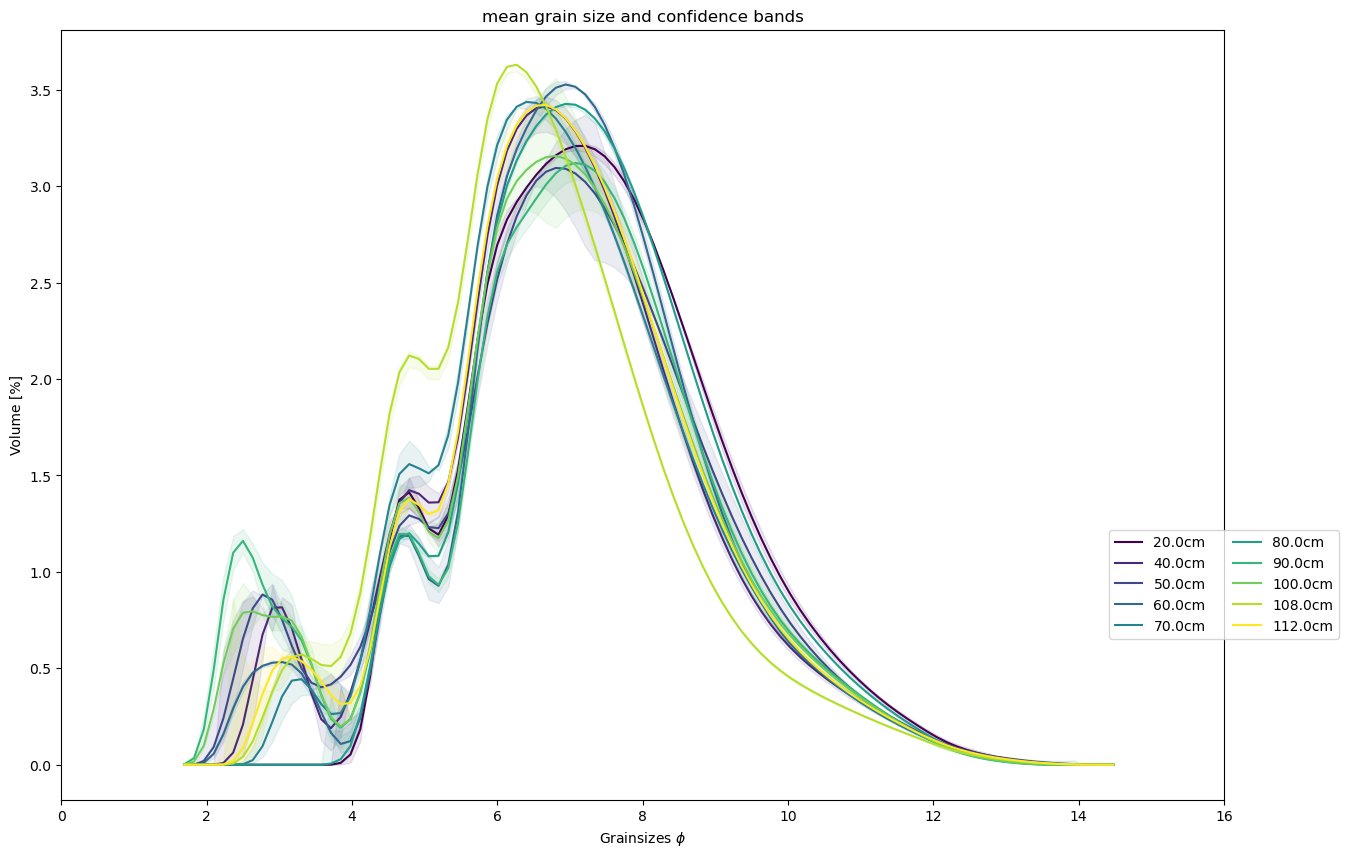

In [13]:
## convert back to % for sanity


n = len(pd.unique(grainsizes_summarize["depth"]))  ## number of curves here
color = cm.viridis(np.linspace(0, 1, n))
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for depth, c in zip(
    pd.unique(grainsizes_summarize["depth"]), color
):  # iterate over all depths and colors --> same lengths!
    plot_curve = grainsizes_summarize.loc[(grainsizes_summarize["depth"] == depth)]
    # depth = plot_curve["depth"].iloc[0]
    plt.plot(
        plot_curve["gs_phi"],
        comp.clr_inv(plot_curve["Vol_clr_mean"]) * 100,
        label=f"{depth}cm",
        color=c,
    )  # interim_ali["Vol_perc_clr"]
    # Add confidence bands
    plt.fill_between(
        plot_curve["gs_phi"],
        comp.clr_inv((plot_curve["Vol_clr_mean"] - plot_curve["Vol_clr_std"])) * 100,
        comp.clr_inv((plot_curve["Vol_clr_mean"] + plot_curve["Vol_clr_std"])) * 100,
        color=c,
        alpha=0.1,
    )
    plt.legend(loc="lower center", ncol=2, bbox_to_anchor=(1, 0.2))

plt.title("mean grain size and confidence bands")
plt.xlabel("Grainsizes $\phi$")
plt.ylabel("Volume [%]")
plt.xlim(0, 16)
plt.show()